<a href="https://colab.research.google.com/github/kalpanibhagya/EmergencyAppsReviews/blob/datafileseparation/LdaTopicmodeling1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task 5**

**Important Note :** 

**Run this file in Google Co labs.** 

Because there might be issues come in when running in jupyter notebook.
The code is perfectly working in co labs

 **Note that prior to run code in colabs upload following two files from
data/Task 5/input in project folder**

*   **Emergency Plus.csv**
*   **Red Cross First Aid.csv**

You can find the same files from data/Task 1/Result (simply the input for this task is output from the task 1) as well,  



**Objectives**

1.   Finding out most discussed 10 topics using LDA

**Aditional Steps followed**

1.   Finding out the performance of the generated LDA
2.   Finding out best optimal number of topics for a better model
3.   Analysis using pyLadvis

In the report ,
 

1.   Fig. 6
2.  Tabel III
3. Fig. 7
4. Tabel IV
5. Fig. 8
6. Fig. 9  are generated from running this code file. 

You can find the exact places for above figures and tables by refering to the comments in the code.
eg:-

a.png



In [6]:
pip install gensim==3.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import spacy
import nltk

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'use'])
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [22]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from tabulate import tabulate
import pyLDAvis
import pyLDAvis.gensim_models as genismnvis  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

topicsname=[]
num_topics =10
bigramDataWords = []
trigramDataWords = []
EvaluationResults =[]
appDetailInputsForLDA =[]
ldaModelDetailsTfAppWise =[]
ldaModelDetailsTfIdfAppWise =[]

#function for preprocessing Data
def PreProcessReviewData(reviewData):
    for review in reviewData:
        yield gensim.utils.simple_preprocess(str(review), deacc=True, min_len=2)  # deacc=True removes punctuations

#function for removing stopwords
def removeStopWords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

#function for bigram creation 
def make_bigrams(texts):
    for doc in texts:
        x = bigram_mod[doc]
        bigramDataWords.append(x)
    return bigramDataWords

#function for trigram creation 
def make_trigrams(texts):
    for doc in texts:
        y = trigram_mod[bigram_mod[doc]]
        trigramDataWords.append(y)
    return trigramDataWords

#function for lemmatization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#function for training LDA model with Tf corpus
def TrainLdaModelWithTf(corpus, id2word, topics = 10, passes= 10, iterations =50) :
    ldaModel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=topics,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=passes,
                                            alpha='auto',
                                            per_word_topics=True,
                                            iterations=iterations)
    return ldaModel

#function for training LDA model with TfIdf corpus
def TrainLdaModelWithTfIdf(corpus, id2word, topics = 10, passes= 10, iterations =50) :
    ldaModel = gensim.models.LdaMulticore(corpus=corpus,
                                            id2word=id2word,
                                            num_topics= topics,
                                            random_state=100,
                                            chunksize=100,
                                            passes=passes,
                                            per_word_topics=True,
                                            iterations= iterations)
    return ldaModel

#function for evaluate LDA model
def EvaluatePerformance(appName, corpus, ldaModel, corpusType):
  results =[appName, corpusType]
  perplexity = ldaModel.log_perplexity(corpus)

  # Compute CV Coherence Score
  cvCoherenceModel = CoherenceModel(model=ldaModel, texts=lemmatizedData, dictionary=id2word, coherence='c_v')
  cvCoherence = cvCoherenceModel.get_coherence()

  # Compute umass Coherence Score
  uMassCoherenceModel = CoherenceModel(model=ldaModel, texts=lemmatizedData, dictionary=id2word, coherence='u_mass')
  uMassCoherence = uMassCoherenceModel.get_coherence()

  results.append(perplexity)
  results.append(cvCoherence)
  results.append(uMassCoherence)

  return results

#function for printing words in the topic
def PrintTopicWords(wordSet):
  topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in wordSet]
  for topic,words in topics_words:
    print(str(topic)+ "::"+ str(words))

#function for plpting LDA model generated topics
def PlottingResults(ldamodel, corpus, id2word):
  pyLDAvis.enable_notebook()
  vis = genismnvis.prepare(ldamodel, corpus, id2word)
  return vis


apps = ['Emergency Plus.csv', 'Red Cross First Aid.csv']

for i in range(len(apps)) :
  df = pd.read_csv('/content/'+apps[i])
  reviewDataList = df['Review'].values.tolist()

  #preprocessing using genism simple pre process
  reviewDataWords = list(PreProcessReviewData(reviewDataList))

  #stopword removal using nltk stop words
  reviewDataWordsWithoutStopWords = removeStopWords(reviewDataWords)

  # bigram trigram models
  bigram = gensim.models.Phrases(reviewDataWords, min_count=5, threshold=100)
  trigram = gensim.models.Phrases(bigram[reviewDataWords], threshold=100)

  bigram_mod = gensim.models.phrases.Phraser(bigram)
  trigram_mod = gensim.models.phrases.Phraser(trigram)
  
  #creating bigram trigram models from the data set
  dataWordsWithbigrams = make_bigrams(reviewDataWordsWithoutStopWords)
  dataWordsWithTrigrams = make_trigrams(dataWordsWithbigrams)

  #lemmatizing data set
  lemmatizedData = lemmatization(dataWordsWithTrigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
 
  #create dictionary as the input for lda model
  id2word = corpora.Dictionary(lemmatizedData)

  # Create Corpus
  texts = lemmatizedData

  # create corpus with Term Document Frequency
  corpusTf = [id2word.doc2bow(text) for text in texts]

  #create corpus with tf-idf
  tfidf = gensim.models.TfidfModel(corpusTf)
  corpusTfidf = tfidf[corpusTf]
  
  #store details in dictionary for use later for evaluation
  dictionary = {'appName':apps[i],'id2word':id2word, 'lemmatized': lemmatizedData, 'tf' : corpusTf, 'tfIdf': corpusTfidf }
  appDetailInputsForLDA.append(dictionary)

  ldaModelTfDetails =[]
  ldaModelTfIdfDetails =[]

  ldaModelTf = TrainLdaModelWithTf(corpusTf, id2word)
  ldaModelTfWords = ldaModelTf.show_topics(num_topics=10, num_words=10,formatted=False)
  print("\n 10 Topics obtained from the reviews of "+apps[i]+ " - Tf Corpus")
  PrintTopicWords(ldaModelTfWords)   #Fig. 6 in report displays this result
  #pprint(ldaModelTf.print_topics()) -print with probabilities
  results = EvaluatePerformance(apps[i], corpusTf, ldaModelTf, corpusType = 'TF')
  EvaluationResults.append(results)

  #Store details to utilize when plotting graphs
  ldaModelTfDetails.append(ldaModelTf)
  ldaModelTfDetails.append(corpusTf)
  ldaModelTfDetails.append(id2word)
  ldaModelDetailsTfAppWise.append(ldaModelTfDetails)

  ldaModelTfIdf = TrainLdaModelWithTfIdf(corpusTfidf, id2word)
  ldaModelTIdffWords = ldaModelTfIdf.show_topics(num_topics=10, num_words=10,formatted=False)
  print("\n 10 Topics obtained from the reviews of "+apps[i]+ " - TfIdf Corpus")
  PrintTopicWords(ldaModelTIdffWords) #Fig. 6 in report displays this result
  #pprint(ldaModelTfIdf.print_topics()) -print with probabilities
  results = EvaluatePerformance(apps[i], corpusTfidf, ldaModelTfIdf, corpusType = 'TF-IDF')
  EvaluationResults.append(results)
  
  #Store details to utilize when plotting graphs
  ldaModelTfIdfDetails.append(ldaModelTfIdf)
  ldaModelTfIdfDetails.append(corpusTfidf)
  ldaModelTfIdfDetails.append(id2word)
  ldaModelDetailsTfIdfAppWise.append(ldaModelTfIdfDetails)

print (tabulate(EvaluationResults, headers=["App Name", "Corpus Type" "Perplexity", "Cv coherence score", "U mass Coherence score"]))#Tabel III in report displays this result


 10 Topics obtained from the reviews of Emergency Plus.csv - Tf Corpus
0::['open', 'show', 'crash', 'accurate', 'time', 'handy', 'lot', 'release', 'standard', 'km']
1::['app', 'emergency', 'location', 'phone', 'great', 'need', 'gps', 'address', 'good', 'service']
2::['try', 'iphone', 'much', 'fire', 'actually', 'application', 'dial', 'put', 'today', 'cause']
3::['useful', 'easy', 'feature', 'mobile', 'current', 'helpful', 'check', 'real', 'install', 'developer']
4::['way', 'correct', 'away', 'address', 'live', 'however', 'lose', 'valuable', 'dangerous', 'wrong']
5::['excellent', 'life_save', 'spot', 'mean', 'serious', 'blue', 'available', 'function', 'guy', 'hope']
6::['well', 'recommend', 'still', 'tell', 'able', 'button', 'send', 'never', 'people', 'really']
7::['work', 'update', 'turn', 'long', 'fix', 'old', 'house', 'new', 'case', 'poison']
8::['download', 'place', 'brilliant', 'list', 'rural', 'especially', 'nice', 'big', 'bad', 'know']
9::['idea', 'home', 'also', 'great', 'see',

In [14]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True,
                                            iterations=50)
                                            
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [15]:
def PlotCoherenceValueAgainstNumofTopics(appName, model, coherence_values):
  limit=40; start=2; step=6;
  x = range(start, limit, step)
  plt.plot(x, coherence_values)
  plt.title(appName)
  plt.xlabel("Num Topics")
  plt.ylabel("Coherence score "+ model)
  plt.legend(("coherence_values"), loc='best')
  plt.show()


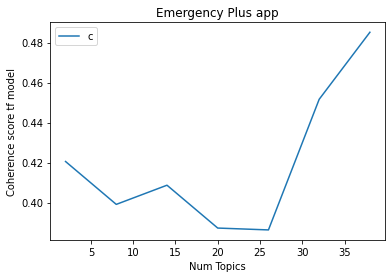

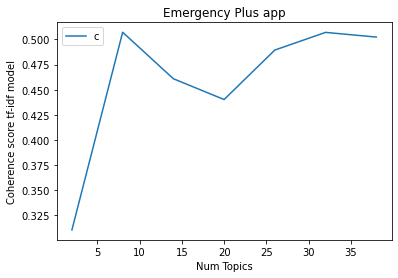

In [16]:
#appDetailInputsForLDA containing details related to emergency app
##Fig. 7 in report displays this result
##Tabel IV  in report is made refferring to the results from the graph
model_list, coherence_values = compute_coherence_values(dictionary=appDetailInputsForLDA[0]['id2word'], corpus=appDetailInputsForLDA[0]['tf'], texts=appDetailInputsForLDA[0]['lemmatized'], start=2, limit=40, step=6)
PlotCoherenceValueAgainstNumofTopics("Emergency Plus app", "tf model", coherence_values)

model_list, coherence_values = compute_coherence_values(dictionary=appDetailInputsForLDA[0]['id2word'], corpus=appDetailInputsForLDA[0]['tfIdf'], texts=appDetailInputsForLDA[0]['lemmatized'], start=2, limit=40, step=6)
PlotCoherenceValueAgainstNumofTopics("Emergency Plus app", "tf-idf model", coherence_values)

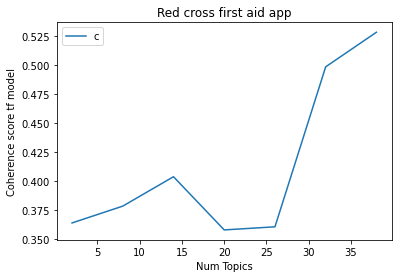

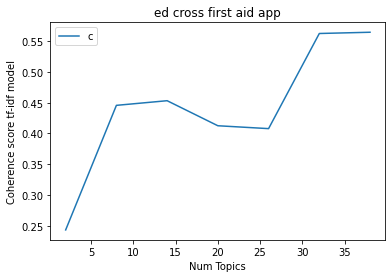

In [17]:
#appDetailInputsForLDA containing details related to red cross first aid app
##Fig. 7 in report displays this result
##Tabel IV  in report is made refferring to the results from the graph
model_list, coherence_values = compute_coherence_values(dictionary=appDetailInputsForLDA[1]['id2word'], corpus=appDetailInputsForLDA[1]['tf'], texts=appDetailInputsForLDA[1]['lemmatized'], start=2, limit=40, step=6)
PlotCoherenceValueAgainstNumofTopics("Red cross first aid app", "tf model", coherence_values)

model_list, coherence_values = compute_coherence_values(dictionary=appDetailInputsForLDA[1]['id2word'], corpus=appDetailInputsForLDA[1]['tfIdf'], texts=appDetailInputsForLDA[1]['lemmatized'], start=2, limit=40, step=6)
PlotCoherenceValueAgainstNumofTopics("ed cross first aid app", "tf-idf model", coherence_values)

In [ ]:
# same process is rerunning just changing the num of topics to optimal number of topics.

bigramDataWords = []
trigramDataWords = []
EvaluationResults =[]
appDetailInputsForLDA =[]
ldaModelDetailsTfAppWise =[]
ldaModelDetailsTfIdfAppWise =[]


apps = ['Emergency Plus.csv', 'Red Cross First Aid.csv']

for i in range(len(apps)) :
  if i== 0 :
    numberOfTfTopics = 13
    numberofTfIdfTopics = 8
  else:
      numberOfTfTopics = 14
      numberofTfIdfTopics = 8

  df = pd.read_csv('/content/'+apps[i])
  reviewDataList = df['Review'].values.tolist()

  #preprocessing using genism simple pre process
  reviewDataWords = list(PreProcessReviewData(reviewDataList))

  #stopword removal using nltk stop words
  reviewDataWordsWithoutStopWords = removeStopWords(reviewDataWords)

  # bigram trigram models
  bigram = gensim.models.Phrases(reviewDataWords, min_count=5, threshold=100)
  trigram = gensim.models.Phrases(bigram[reviewDataWords], threshold=100)

  bigram_mod = gensim.models.phrases.Phraser(bigram)
  trigram_mod = gensim.models.phrases.Phraser(trigram)
  
  #creating bigram trigram models from the data set
  dataWordsWithbigrams = make_bigrams(reviewDataWordsWithoutStopWords)
  dataWordsWithTrigrams = make_trigrams(dataWordsWithbigrams)

  #lemmatizing data set
  lemmatizedData = lemmatization(dataWordsWithTrigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
  print(lemmatizedData)

  
  #create dictionary as the input for lda model
  id2word = corpora.Dictionary(lemmatizedData)

  # Create Corpus
  texts = lemmatizedData

  # create corpus with Term Document Frequency
  corpusTf = [id2word.doc2bow(text) for text in texts]

  #create corpus with tf-idf
  tfidf = gensim.models.TfidfModel(corpusTf)
  corpusTfidf = tfidf[corpusTf]
  
  #store details in dictionary for use later for evaluation
  dictionary = {'appName':apps[i],'id2word':id2word, 'lemmatized': lemmatizedData, 'tf' : corpusTf, 'tfIdf': corpusTfidf }
  appDetailInputsForLDA.append(dictionary)

  ldaModelTfDetails =[]
  ldaModelTfIdfDetails =[]

  ldaModelTf = TrainLdaModelWithTf(corpusTf, id2word, numberOfTfTopics)
  ldaModelTfWords = ldaModelTf.show_topics(num_topics=10, num_words=10,formatted=False)
  print("\n ")
  print(numberOfTfTopics)
  print(" Topics obtained from the reviews of "+apps[i]+ " - Tf Corpus")
  PrintTopicWords(ldaModelTfWords)
  #pprint(ldaModelTf.print_topics()) -print with probabilities
  results = EvaluatePerformance(apps[i], corpusTf, ldaModelTf, corpusType = 'TF')
  EvaluationResults.append(results)

  #Store details to utilize when plotting graphs
  ldaModelTfDetails.append(ldaModelTf)
  ldaModelTfDetails.append(corpusTf)
  ldaModelTfDetails.append(id2word)
  ldaModelDetailsTfAppWise.append(ldaModelTfDetails)

  ldaModelTfIdf = TrainLdaModelWithTfIdf(corpusTfidf, id2word, numberofTfIdfTopics)
  ldaModelTIdffWords = ldaModelTfIdf.show_topics(num_topics=10, num_words=10,formatted=False)
  print("\n ")
  print(numberofTfIdfTopics)
  print(" Topics obtained from the reviews of "+apps[i]+ " - TfIdf Corpus")
  PrintTopicWords(ldaModelTIdffWords)
  #pprint(ldaModelTfIdf.print_topics()) -print with probabilities
  results = EvaluatePerformance(apps[i], corpusTfidf, ldaModelTfIdf, corpusType = 'TF-IDF')
  EvaluationResults.append(results)
  
  #Store details to utilize when plotting graphs
  ldaModelTfIdfDetails.append(ldaModelTfIdf)
  ldaModelTfIdfDetails.append(corpusTfidf)
  ldaModelTfIdfDetails.append(id2word)
  ldaModelDetailsTfIdfAppWise.append(ldaModelTfIdfDetails)

[['give', 'wrong', 'address', 'know', 'rest', 'correct'], ['locate', 'correctly', 'give', 'address', 'street', 'away', 'last', 'update', 'text', 'also', 'odd', 'year', 'ago', 'let', 'take', 'time', 'settle', 'sgs'], ['good', 'thank'], [], ['handy'], ['render', 'assistance', 'dehydrate', 'aged', 'sailor', 'water', 'edge', 'reporting', 'concern', 'welfare', 'frustratingly', 'road', 'street', 'pass', 'simple', 'say', 'alpha', 'gps', 'word', 'spot', 'guide', 'ambulance', 'close', 'find', 'rescue', 'day', 'night', 'call', 'assistance', 'come', 'observable', 'street', 'address', 'matter', 'even', 'land', 'metre', 'square'], ['great', 'app', 'sister', 'put', 'shame', 'way', 'update', 'home', 'location', 'gps', 'location', 'work', 'multi', 'level', 'residential', 'building'], ['dangerous', 'app', 'think', 'old', 'address', 'actually', 'gps', 'update', 'waze', 'pick', 'location', 'correctly', 'gps', 'phone', 'issue', 'app', 'dangerous', 'send', 'emergency', 'service', 'wrong', 'location', 'safe

In [18]:
#plotting for emergency app tf corpus
##Fig. 8 in report displays this result
vis =PlottingResults(ldaModelDetailsTfAppWise[0][0], ldaModelDetailsTfAppWise[0][1], ldaModelDetailsTfAppWise[0][2])
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.394528  0.115905       1        1  35.698259
9     -0.113079 -0.243353       2        1  13.838970
6      0.024849 -0.238915       3        1  11.056374
7      0.058646  0.139205       4        1  10.852537
0      0.076240 -0.026501       5        1   6.035974
2      0.099059  0.100266       6        1   5.840115
4      0.012165  0.064396       7        1   4.870755
8      0.069200  0.009236       8        1   4.136825
3      0.082366  0.050845       9        1   4.022280
5      0.085083  0.028915      10        1   3.647910, topic_info=             Term        Freq       Total Category  logprob  loglift
59            app  498.000000  498.000000  Default  30.0000  30.0000
71           work  116.000000  116.000000  Default  29.0000  29.0000
75      emergency  234.000000  234.000000  Default  28.0000  28.0000
20         update   82.000000   82.000000  Default  27.0000  27.0000
0         address  114.000000  114.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1862  underground    3.057404    3.759272  Topic10  -4.8557   3.1044
1863    workplace    3.057404    3.759272  Topic10  -4.8557   3.1044
1843    necessity    3.052479    3.754983  Topic10  -4.8573   3.1039
608     available    6.958181   11.355536  Topic10  -4.0333   2.8212
118          well    3.411822   42.433212  Topic10  -4.7460   0.7903

[386 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
491       3  0.975202          able
88        1  0.983327        access
1310      1  0.964496      accident
361      10  0.910232  accidentally
1081      1  0.964457      accuracy
...     ...       ...           ...
71        4  0.990837          work
1863     10  0.798027     workplace
5         1  0.795373         wrong
5         7  0.173988         wrong
21        4  0.982345          year

[387 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 10, 7, 8, 1, 3, 5, 9, 4, 6])

In [19]:
#plotting for emergency app tf idf corpus
##Fig. 8 in report displays this result
vis =PlottingResults(ldaModelDetailsTfIdfAppWise[0][0], ldaModelDetailsTfIdfAppWise[0][1], ldaModelDetailsTfIdfAppWise[0][2])
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.170388  0.146353       1        1  17.288728
2     -0.125129 -0.155733       2        1  15.139183
1     -0.063596 -0.007410       3        1  13.736807
6      0.053798  0.017057       4        1  10.778548
9     -0.011278 -0.057258       5        1   9.123633
7      0.058639  0.010099       6        1   8.817626
3      0.073775  0.005980       7        1   7.113429
8      0.069356  0.007506       8        1   6.640107
4      0.053577  0.024063       9        1   6.340028
5      0.061246  0.009344      10        1   5.021911, topic_info=          Term       Freq      Total Category  logprob  loglift
61       great  21.000000  21.000000  Default  30.0000  30.0000
367       idea  13.000000  13.000000  Default  29.0000  29.0000
578  excellent   7.000000   7.000000  Default  28.0000  28.0000
122  recommend   8.000000   8.000000  Default  27.0000  27.0000
22        good  15.000000  15.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
518       huge   0.415376   0.921928  Topic10  -5.7392   2.1941
776     modern   0.396704   0.902810  Topic10  -5.7852   2.1690
631        new   0.992383   3.803869  Topic10  -4.8683   1.6477
389    instead   0.570734   1.913914  Topic10  -5.4215   1.7814
23       thank   0.429830   5.805791  Topic10  -5.7050   0.3881

[444 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
236       2  0.769645    ability
491       4  0.823789       able
88        2  0.242085     access
88        3  0.484171     access
88        9  0.242085     access
...     ...       ...        ...
71        4  0.077833       work
1863      7  0.780456  workplace
5         1  0.811994      wrong
5         3  0.135332      wrong
211       3  0.560002        yet

[491 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 7, 10, 8, 4, 9, 5, 6])

In [20]:
#plotting for red cross app tf corpus
##Fig. 8 in report displays this result
vis =PlottingResults(ldaModelDetailsTfAppWise[1][0], ldaModelDetailsTfAppWise[1][1], ldaModelDetailsTfAppWise[1][2])
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.440346 -0.008864       1        1  23.294212
3      0.030425 -0.171863       2        1  17.945404
9     -0.014864  0.397252       3        1  11.859581
5     -0.050192 -0.036971       4        1  10.737479
2     -0.026861 -0.002987       5        1  10.680752
1     -0.054808 -0.046091       6        1   7.486492
0     -0.070910 -0.031949       7        1   5.834802
7     -0.081019 -0.033345       8        1   5.082843
8     -0.087800 -0.032066       9        1   3.752807
4     -0.084318 -0.033115      10        1   3.325628, topic_info=            Term         Freq        Total Category  logprob  loglift
59           app  3048.000000  3048.000000  Default  30.0000  30.0000
61         great  1562.000000  1562.000000  Default  29.0000  29.0000
22          good   809.000000   809.000000  Default  28.0000  28.0000
157       useful   591.000000   591.000000  Default  27.0000  27.0000
176         love   650.000000   650.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
946        serve    12.476588    13.586310  Topic10  -4.8965   3.3183
588        count    12.160512    13.271503  Topic10  -4.9221   3.3161
2163       enjoy    11.834911    12.944575  Topic10  -4.9493   3.3139
1239       state    10.930002    12.039821  Topic10  -5.0288   3.3068
1123  incredibly    10.425440    11.536261  Topic10  -5.0761   3.3023

[334 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
491       6  0.981985        able
88        8  0.981288      access
89        8  0.958239  accessible
445       9  0.961242    accurate
375       9  0.958438      actual
...     ...       ...         ...
1699      7  0.935846       worry
219       7  0.970746       worth
627       4  0.965839       write
5         2  0.993138       wrong
21        4  0.989456        year

[309 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 10, 6, 3, 2, 1, 8, 9, 5])

In [21]:
#plotting for red cross first aid app tf idf corpus
##Fig. 8 in report displays this result
vis =PlottingResults(ldaModelDetailsTfIdfAppWise[1][0], ldaModelDetailsTfIdfAppWise[1][1], ldaModelDetailsTfIdfAppWise[1][2])
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.201466 -0.127178       1        1  17.750209
3      0.174145  0.014139       2        1  14.587634
2     -0.044145 -0.194022       3        1  11.904974
5     -0.032342  0.196581       4        1   9.981684
7     -0.065612  0.044928       5        1   9.746450
6      0.047865  0.075898       6        1   9.109810
9      0.058941  0.103161       7        1   8.483729
4     -0.127134 -0.035713       8        1   6.420042
0     -0.090863  0.004153       9        1   6.208606
1     -0.122321 -0.081948      10        1   5.806862, topic_info=          Term        Freq       Total Category  logprob  loglift
490    helpful  275.000000  275.000000  Default  30.0000  30.0000
176       love  158.000000  158.000000  Default  29.0000  29.0000
61       great  302.000000  302.000000  Default  28.0000  28.0000
159    awesome   94.000000   94.000000  Default  27.0000  27.0000
157     useful  207.000000  207.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
372      never   24.587047   35.461563  Topic10  -3.4617   2.4799
330  important   15.432370   25.607506  Topic10  -3.9275   2.3397
3         know   23.639994   83.435875  Topic10  -3.5010   1.5850
151       need    7.798554   90.556927  Topic10  -4.6100   0.3941
59         app    5.319228  303.251668  Topic10  -4.9926  -1.1971

[445 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
491       3  0.690282        able
491       6  0.069028        able
491       8  0.207084        able
1128      3  0.977417  absolutely
89        5  0.885386  accessible
...     ...       ...         ...
219       9  0.840906       worth
627       3  0.867095       write
5         1  0.948225       wrong
21        3  0.714863        year
21        4  0.238288        year

[492 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 4, 3, 6, 8, 7, 10, 5, 1, 2])